In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoCV, RidgeCV

from src.plots.plots import plot_singular_values_vs_rank
from src.decomposition.RPCA import RPCA

In [2]:
train = pd.read_csv(os.path.join("data", "train.csv"))
unique_m = pd.read_csv(os.path.join("data", "unique_m.csv"))

target = train.pop("critical_temp")
unique_m.drop(["critical_temp", "material"], axis=1, inplace=True)
unique_m = unique_m.select_dtypes(np.number).astype(np.int64)
X = pd.concat([train, unique_m], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, target)

## The Data Is Absurdly Noisy

### Standard SVD Saying That Optimal Cutoff Rank Is Only A Few Below Original Rank! Nonsense!

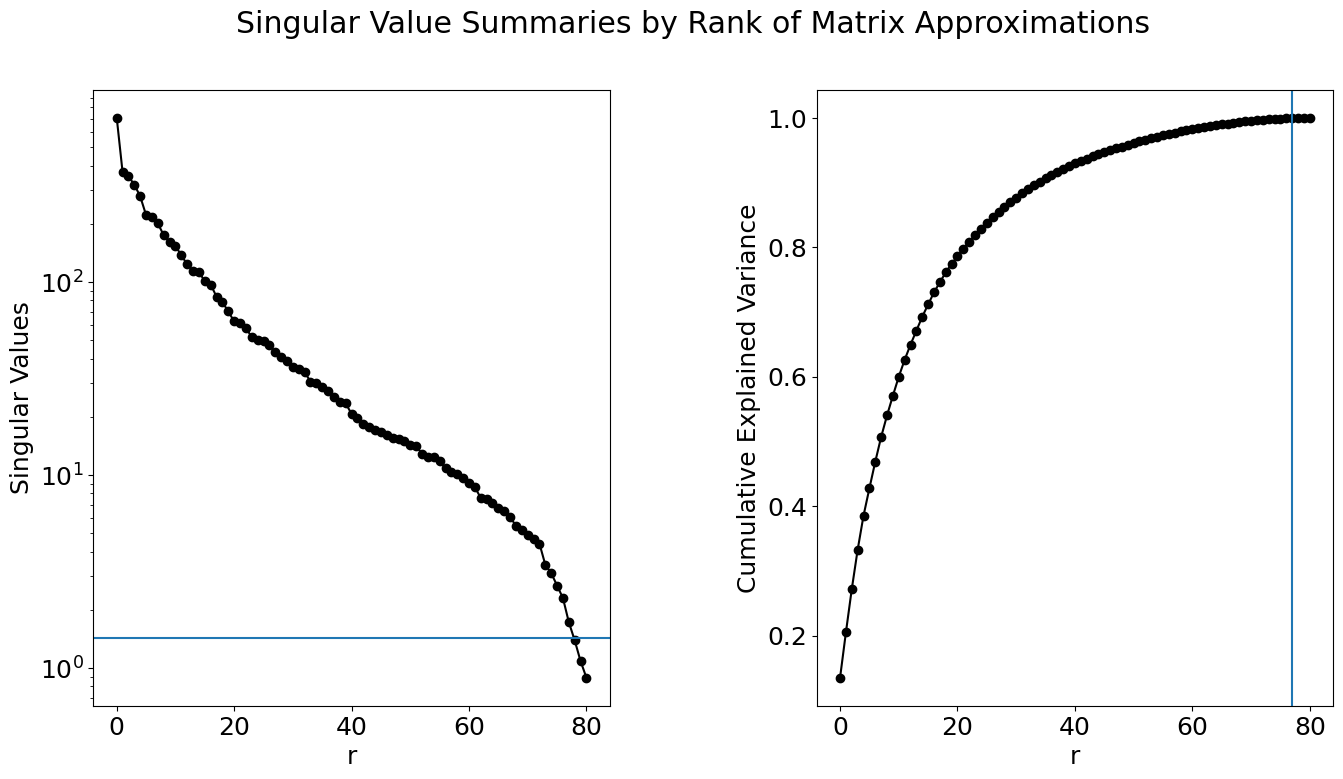

The Gavish-Donoho Hard Cutoff Corresponds To R='77'


In [3]:
r = plot_singular_values_vs_rank(X_train.select_dtypes(np.float64), method="standard", max_iters=10000, svt_tol=10**(-5))
print("The Gavish-Donoho Hard Cutoff Corresponds To R='{0}'".format(r))

### Robust PCA Comes To The Rescue

  3%|▎         | 291/10000 [02:11<1:13:02,  2.22it/s]


SUCCESS: Convergence at Iteration '291'!


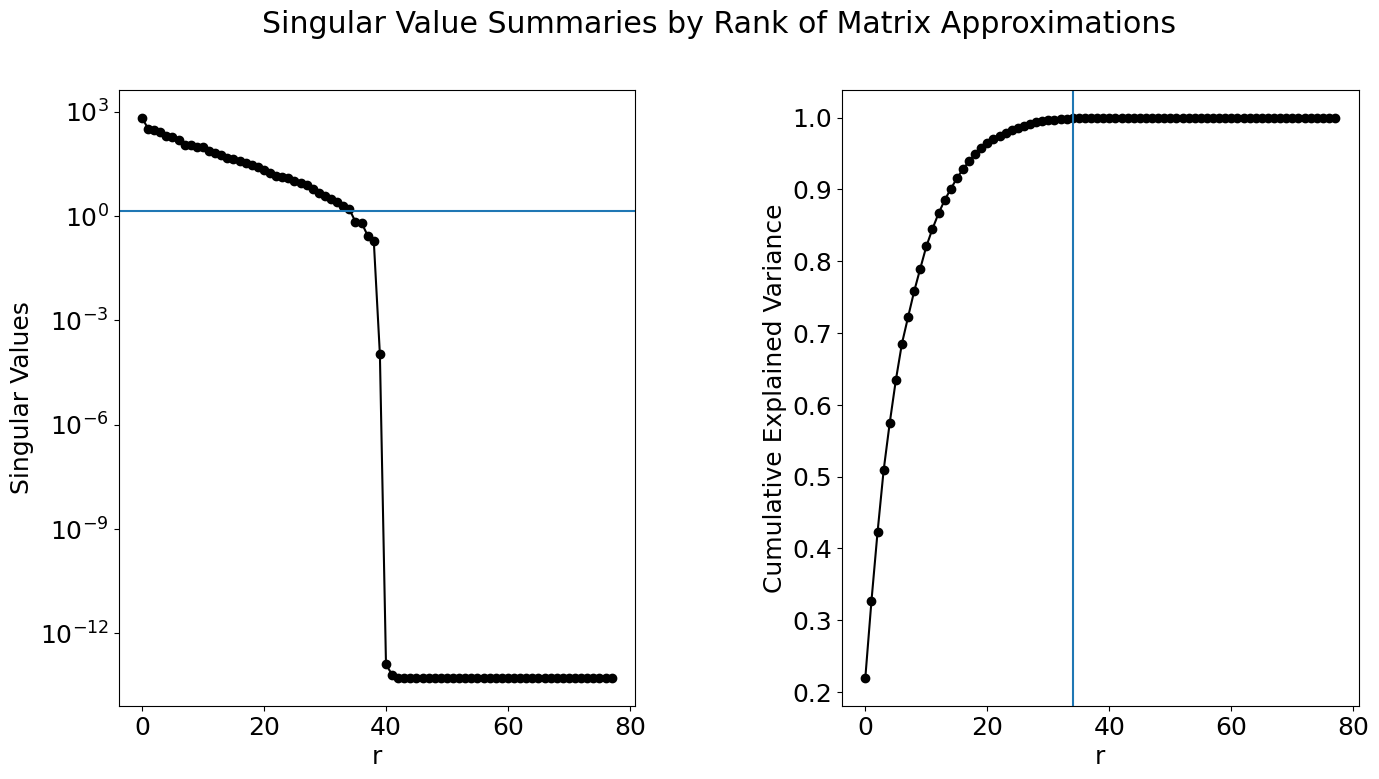

The Gavish-Donoho Hard Cutoff Corresponds To R='34'


In [6]:
r = plot_singular_values_vs_rank(X_train.select_dtypes(np.float64), method="rpca", max_iters=10000, svt_tol=10**(-5))
print("The Gavish-Donoho Hard Cutoff Corresponds To R='{0}'".format(r))

We will fit four models that differ in whether RPCA is used or whether unique_m is included.

In [23]:
rpca_numeric_transformer = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("rpca", RPCA(n_components=34, svt_tol=10**-4))
    ]
)
numeric_features = X_train.select_dtypes(np.float64).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), numeric_features)
    ]
)

rpca_preprocessor = ColumnTransformer(
    transformers=[
        ("num", rpca_numeric_transformer, numeric_features)
    ]
)

lasso_cv_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("lassocv", LassoCV(max_iter=10000, n_jobs=-1))
    ]
)

lasso_rpca_cv_pipe = Pipeline(
    [
        ("preprocessor", rpca_preprocessor),
        ("lassocv", LassoCV(max_iter=10000, n_jobs=-1))
    ]
)

In [24]:
lasso_cv_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lassocv', LassoCV(max_iter=10000, n_jobs=-1))])

In [25]:
lasso_cv_pipe['lassocv'].coef_

array([ 8.04207573e-01,  8.46172649e+00, -9.15265472e+00, -0.00000000e+00,
       -0.00000000e+00, -3.54918406e+00,  3.04158841e+00,  7.97240638e+00,
        1.72443434e-01,  0.00000000e+00, -6.43981239e+00, -0.00000000e+00,
        2.81855926e+00, -1.61697067e-01,  3.67096999e-03,  0.00000000e+00,
        9.13105869e+00,  1.11827773e+01,  3.00152092e+00, -1.04758860e+01,
       -0.00000000e+00, -0.00000000e+00,  4.16118616e+00, -3.20231611e+00,
       -0.00000000e+00,  0.00000000e+00,  1.95674470e+00,  6.54050565e+00,
       -1.63972069e+00, -9.49618836e+00,  7.84950646e+00, -7.82539153e+00,
        4.13397889e+00, -8.60531799e-01,  3.59457281e+00, -3.20513426e+00,
       -1.91380549e+00, -1.31974622e+00,  4.35831876e-01,  7.19632974e-01,
       -3.33389324e-01,  0.00000000e+00,  7.94454369e+00,  2.43214032e+00,
       -1.13935085e+01,  0.00000000e+00, -4.51637313e+00, -1.50619129e+01,
       -1.65980495e+00,  1.85741906e+01, -7.46402802e+00,  1.02467225e+00,
       -2.72367150e+00,  